In [1]:
import os
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import numpy as np
import h5py
import time

drive_path = os.path.join(os.getenv('HOME'), 'work/allen/data/sdk_new_100')
view_paths_fn = os.path.join(os.getenv('HOME'), 'work/allen/data/TopView/top_view_paths_10.h5')

# When downloading 3D connectivity data volumes, what resolution do you want (in microns)?  
# Options are: 10, 25, 50, 100
resolution_um=10

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
manifest_file = os.path.join(drive_path, "manifest.json")

mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)
ontology = mcc.get_ontology()
# get some info on the isocortex
isocortex = ontology['Isocortex']

# open up a pandas dataframe of all of the experiments
experiments = mcc.get_experiments(dataframe = True, 
                                  injection_structure_ids = [isocortex['id']], 
                                  cre = False)
print "%d total experiments" % len(experiments)

view_paths_file = h5py.File(view_paths_fn, 'r')
view_lut = view_paths_file['view lookup'][:]
view_paths = view_paths_file['paths'][:]
view_paths_file.close()

eid = experiments.iloc[0].id
row = experiments.iloc[0]
print "Processing experiment %d" % eid
print row
    
# get some injection data
print "getting injection density"
in_d, in_info = mcc.get_projection_density(eid)

# map to cortex top view
t0 = time.time()
output_pd = np.zeros(view_lut.shape, dtype=in_d.dtype)
# all pixels in surface view with a stream line
ind = np.where(view_lut > -1)
ind = zip(ind[0], ind[1])
for curr_ind in ind:
    curr_path_id = view_lut[curr_ind]
    curr_path = view_paths[curr_path_id, :]
    curr_pd_line = in_d.flat[curr_path]
    #curr_max_ind = curr_path[np.argmax(curr_pd_line)]
    #output_pd[curr_ind] = in_d.flat[curr_max_ind]
    output_pd[curr_ind] = np.mean(curr_pd_line)
t1 = time.time()
total = t1 - t0
print "Time elapsed for integration: %0.0f s" % total

127 total experiments
Processing experiment 180435652
gender                                                                   M
id                                                               180435652
injection-coordinates                                   [7820, 4250, 9870]
injection-structures     [{u'abbreviation': u'TEa', u'color': u'15B0B3'...
strain                                                            C57BL/6J
structure-abbrev                                                      PERI
structure-color                                                     0E9684
structure-id                                                           922
structure-name                                             Perirhinal area
transgenic-line                                                           
Name: 180435652, dtype: object
getting injection density
Time elapsed for integration: 23 s


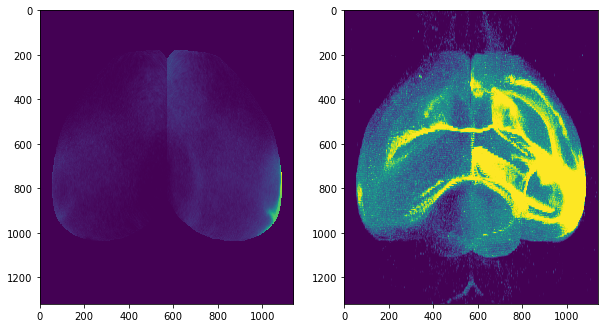

In [2]:
# show the results
import matplotlib.pyplot as plt
%matplotlib inline

# check whether two plots look similar (they don't)
fig = plt.figure(figsize = (10,20))
ax = fig.add_subplot(121)
h = ax.imshow(output_pd)
ax = fig.add_subplot(122)
h = ax.imshow(np.max(in_d, axis=1))